# Scikit-fingerprints intro

Scikit-fingerprints is the scikit-learn compatible library for computing molecular fingerprints and other molecular ML & chemoinformatics tasks, based on RDKit.

GitHub: https://github.com/scikit-fingerprints/scikit-fingerprints

Documentation: https://scikit-fingerprints.readthedocs.io/latest/

## Datasets

First, we will load some data - the BBBP (blood-brain barrier penetration) from [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Scikit-fingerprints has functions to download and load datasets from MoleculeNet, TDC, and others in `skfp.datasets` module ([documentation](https://scikit-fingerprints.readthedocs.io/latest/modules/datasets.html)). They are hosted [on HuggingFace](https://huggingface.co/scikit-fingerprints) for high availability.

In [1]:
from skfp.datasets.moleculenet import load_bbbp


smiles_list, y = load_bbbp()

In [2]:
smiles_list[:5]

['[Cl].CC(C)NCC(O)COc1cccc2ccccc12',
 'C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl',
 'c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO3)=O',
 'C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C',
 'Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O']

In [3]:
y

array([1, 1, 1, ..., 1, 1, 1], shape=(2039,))

The task is **binary classification** - predict if a molecule can pass through the blood-brain barrier.

Let's parse SMILES as molecules. Parsing classes (input and output) are implemented as classes with `.transform()` method in scikit-fingerprints, in `skfp.preprocessing` module ([documentation](https://scikit-fingerprints.readthedocs.io/latest/modules/preprocessing.html)).

Let's compare RDKit and scikit-fingerprints. The task is to parse all SMILES as molecules.

In [4]:
from rdkit.Chem import MolFromSmiles

mols_rdkit = [MolFromSmiles(smiles) for smiles in smiles_list]
mols_rdkit[:5]

[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not removing hydrogen atom without neighbors
[21:10:18] WARNING: not r

In [5]:
from skfp.preprocessing import MolFromSmilesTransformer


mol_from_smiles = MolFromSmilesTransformer()

mols_skfp = mol_from_smiles.transform(smiles_list)
mols_skfp[:5]

[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not removing hydrogen atom without neighbors
[21:10:19] WARNING: not r

This is a list of regular RDKit `Mol` objects, we can draw them or combine with other RDKit-compatible libraries.

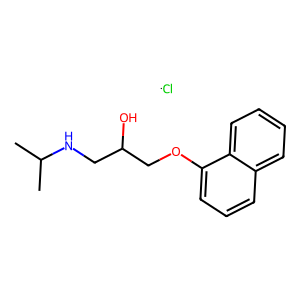

In [6]:
from rdkit.Chem import Draw

Draw.MolToImage(mols_skfp[0])

A few remarks:

1. We have inconvenient warnings. What if we want to get rid of them?
2. We may want to monitor progress.
3. What happens if we have wrong SMILES that can't be parsed?

Let's see a robust RDKit implementation that can do those things.

In [7]:
from rdkit.rdBase import DisableLog, EnableLog
from tqdm import tqdm


# we need try/finally to make sure logs are turned on after this
try:
    DisableLog("rdApp.*")

    rdkit_mols = []
    for smiles in tqdm(smiles_list):
        mol = MolFromSmiles(smiles)
        if mol is not None:
            rdkit_mols.append(mol)
finally:
    EnableLog("rdApp.*")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 5153.93it/s]


And with scikit-fingerprints:

In [8]:
mol_from_smiles = MolFromSmilesTransformer(
    valid_only=True, suppress_warnings=True, verbose=True
)
skfp_mols = mol_from_smiles.transform(smiles_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 5223.02it/s]


One problem - if we remove some molecules, what about labels? Which ones were removed? We also need to filter them!

With RDKit, we need to iterate on both mols and labels for that.

Scikit-fingerprints has `.transform_x_y()` method for that cases, useful when you use `valid_only=True`.

In [9]:
try:
    DisableLog("rdApp.*")

    rdkit_mols = []
    rdkit_labels = []
    for smiles, label in tqdm(zip(smiles_list, y), total=len(y)):
        mol = MolFromSmiles(smiles)
        if mol is not None:
            rdkit_mols.append(mol)
            rdkit_labels.append(label)
finally:
    EnableLog("rdApp.*")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 5939.14it/s]


In [10]:
mol_from_smiles = MolFromSmilesTransformer(
    valid_only=True, suppress_warnings=True, verbose=True
)
skfp_mols, skfp_labels = mol_from_smiles.transform_x_y(smiles_list, y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 5304.05it/s]


**Exercise 1**

Load the SIDER dataset from MoleculeNet benchmark, and parse it as molecules. Keep only valid molecules and their labels, and suppress parsing warnings.

Use [scikit-fingerprints documentation](https://scikit-fingerprints.readthedocs.io/latest/api_reference.html) as necessary.

Its task is to predict adverse drug reactions (ADRs) as drug side effects to 27 system organ classes. Thus, we have 27 binary classification tasks, and a matrix of labels instead of a vector.

**Warning:** name variables so that you don't override those from BBBP, e.g. `smiles_list_sider`, `y_sider`, `mols_sider`.

In [11]:
from skfp.datasets.moleculenet import load_sider


mol_from_smiles = MolFromSmilesTransformer(valid_only=True, suppress_warnings=True)

smiles_list_sider, y_sider = load_sider()

mols_sider, y_sider = mol_from_smiles.transform_x_y(smiles_list_sider, y_sider)

## Molecular fingerprints

Molecular fingerprints are the basic way of turning molecules into feature vectors for ML. We can divide them roughly into 4 types:

1. **Descriptors** - predefined sets of real numbers, e.g. molecular mass, logP, elements distribution. Examples include [RDKit 2D descriptors](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.RDKit2DDescriptorsFingerprint.html), [Mordred](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.MordredFingerprint.html), and [VSA](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.VSAFingerprint.html).

2. **Substructural fingerprints** - predefined set of substructures to detect, e.g. elements, functional groups, rings. Defined as a list of SMARTS patterns, typically created by expert chemists. Examples include [MACCS](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.MACCSFingerprint.html), [Klekota-Roth](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.KlekotaRothFingerprint.html), and [Laggner](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.LaggnerFingerprint.html).

3. **Hashed fingerprints** - most algorithmic in nature. Each one defines a particular subgraph shape, e.g. circular neighborhoods, the shortest paths between pairs of atoms, or short walks. All such subgraphs are extracted for a molecule, assigned integer identifiers, and hashed into the output feature vector. Examples include [ECFP (Morgan)](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.ECFPFingerprint.html), [Atom Pair](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.AtomPairFingerprint.html), and [RDKit fingerprint](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.RDKitFingerprint.html).

4. **Other** - some fingerprints are pretty hard to assign into one of those above categories, mostly those based on 3D conformations. They are often histograms or other statistics of interatomic distances with various weighting schemes (e.g., partial charge). Examples include [USR](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.USRFingerprint.html), [Autocorrelation](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.AutocorrFingerprint.html), and [MoRSE](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.MORSEFingerprint.html).

RDKit has:
- a few descriptors available, but not as classes and in various places (e.g. RDKit 2D descriptors, VSA)
- 1 substructural fingerprint (MACCS)
- 10 hashed fingerprints (Atom Pair, Avalon, ECFP, ErG, Layered, MHFP, Pattern, RDKit, SECFP, Topological Torsion)
- a few other fingerprints (some as functions, other as classes)

Probably the biggest practical problem is that all of the above have very varied interfaces and modules - they need to be imported from 9 places!

Scikit-fingerprints currently has 35 fingerprints, all with unified scikit-learn interface.

Let's see an example with ECFP fingerprint, which has a generator interface in RDKit, a very nice API.

In [12]:
import numpy as np
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator


# warning: by default computes ECFP6, not typically used ECFP4!
gen = GetMorganGenerator(fpSize=2048, radius=2)

X = [gen.GetFingerprintAsNumPy(mol) for mol in skfp_mols]
X = np.vstack(X)
X

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], shape=(2039, 2048), dtype=uint8)

And with scikit-fingerprints:

In [13]:
from skfp.fingerprints import ECFPFingerprint


# ECFP4 by default
ecfp_fp = ECFPFingerprint()

X = ecfp_fp.transform(skfp_mols)

X

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], shape=(2039, 2048), dtype=uint8)

**Exercise 2**

Calculate MACCS fingerprint with RDKit ([documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html)) and with scikit-fingerprints ([documentation](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.MACCSFingerprint.html)).

**Warning:** in RDKit implementation, first feature of MACCS is actually unused and is always 0! It is just to index features from 1. Remove the first column in RDKit features. Scikit-fingerprints does this automatically.

In [14]:
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint


X_rdkit = np.vstack([GetMACCSKeysFingerprint(mol) for mol in skfp_mols])
X_rdkit

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]], shape=(2039, 167))

In [15]:
from skfp.fingerprints import MACCSFingerprint


maccs_fp = MACCSFingerprint()
X_skfp = maccs_fp.transform(skfp_mols)
X_skfp

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]], shape=(2039, 166), dtype=uint8)

One very nice thing about scikit-fingerprints is **full parallelism support**. You can pass `n_jobs` to any fingerprint, and it will be computed on that many cores. It can really speed up computation, particularly for computationally expensive fingerprints, like substructure ones, which have to check many SMARTS patterns.

Let's see a comparison on Laggner fingerprint, which computes 307 functional groups. SIDER dataset is used here, as it is larger - BBBP is too small to really benefit from parallelism.

In [16]:
from time import time
from skfp.fingerprints import LaggnerFingerprint


laggner_fp = LaggnerFingerprint()

start = time()
laggner_fp.transform(mols_sider)
end = time()
print(f"Sequential time: {end - start}")

# -1 uses as many processes as you have cores
laggner_fp = LaggnerFingerprint(n_jobs=-1)

start = time()
laggner_fp.transform(mols_sider)
end = time()
print(f"Parallel time: {end - start}")

Sequential time: 5.44761061668396
Parallel time: 4.43120002746582


If you want to inspect feature names for substructural fingerprints, it's more or less impossible with RDKit, or at least very challenging. Scikit-fingerprints exposes them with standard `.get_feature_names_out()` method.

This also enables great integrations with scikit-learn + Pandas or Polars, since DataFrames get feature names out-of-the-box.

In [17]:
laggner_fp.get_feature_names_out()

array(['Primary_carbon', 'Secondary_carbon', 'Tertiary_carbon',
       'Quaternary_carbon', 'Alkene', 'Alkyne', 'Allene', 'Alkylchloride',
       'Alkylfluoride', 'Alkylbromide', 'Alkyliodide', 'Alcohol',
       'Primary_alcohol', 'Secondary_alcohol', 'Tertiary_alcohol',
       'Dialkylether', 'Dialkylthioether (aliphatic O)', 'Alkylarylether',
       'Diarylether', 'Alkylarylthioether (aliphatic S)',
       'Diarylthioether', 'Oxonium', 'Amine', 'Primary_aliph_amine',
       'Secondary_aliph_amine', 'Tertiary_aliph_amine',
       'Quaternary_aliph_ammonium', 'Primary_arom_amine',
       'Secondary_arom_amine', 'Tertiary_arom_amine',
       'Quaternary_arom_ammonium', 'Secondary_mixed_amine',
       'Tertiary_mixed_amine', 'Quaternary_mixed_ammonium', 'Ammonium',
       'Alkylthiol', 'Dialkylthioether (aliphatic S)',
       'Alkylarylthioether (aliphatic O)', 'Disulfide',
       '1,2-Aminoalcohol', '1,2-Diol', '1,1-Diol', 'Hydroperoxide',
       'Peroxo', 'Organolithium_compounds', 'Or

Let's do some machine learning now! At this point, molecules are turned into feature vectors and any tabular ML algorithm works.

We could use [scaffold split](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.model_selection.scaffold_train_test_split.html) to create train and test sets. For many benchmarks, however, indexes are already precomputed for fair comparison, e.g. in [Open Graph Benchmark (OGB)](https://scikit-fingerprints.readthedocs.io/latest/modules/datasets/generated/skfp.datasets.moleculenet.load_ogb_splits.html) for MoleculeNet datasets.

In [18]:
from skfp.datasets.moleculenet import load_ogb_splits
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


train_idxs, valid_idxs, test_idxs = load_ogb_splits(dataset_name="BBBP")

# we don't tune anything, so let's merge training and validation
train_idxs = train_idxs + valid_idxs

ecfp_fp = ECFPFingerprint()
X = ecfp_fp.transform(skfp_mols)

X_train = X[train_idxs]
y_train = skfp_labels[train_idxs]

X_test = X[test_idxs]
y_test = skfp_labels[test_idxs]

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.2%}")

AUROC: 70.23%


But we can simplify that! With RDKit, you have to do as above: SMILES -> Mol -> fingerprint -> array, and only then do ML. But what if you want to:

- change fingerprint hyperparameters, e.g. ECFP radius?
- tune hyperparameters of both fingerprint and model?
- serialize this after training, and load on production server?

First, fingerprints take SMILES input, and will transform them inside as necessary to `Mol` objects. This also works in batches in parallel, so it is also quite memory-efficient.

Second, scikit-fingerprints supports full scikit-learn interface. In particular, it means that it can e.g. be used in pipelines, in hyperparameter tuning, fingerprints can be serialized, and all other stuff.

Let's see an example from start to end.

In [23]:
from sklearn.pipeline import make_pipeline


smiles_list, y = load_bbbp()
smiles_list = np.array(smiles_list)

train_idxs, valid_idxs, test_idxs = load_ogb_splits(dataset_name="BBBP")
train_idxs = train_idxs + valid_idxs

smiles_train = smiles_list[train_idxs]
smiles_test = smiles_list[test_idxs]

y_train = y[train_idxs]
y_test = y[test_idxs]

pipeline = make_pipeline(
    ECFPFingerprint(), RandomForestClassifier(n_jobs=-1, random_state=0)
)
pipeline.fit(smiles_train, y_train)

y_pred_proba = pipeline.predict_proba(smiles_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.2%}")

[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not removing hydrogen atom without neighbors
[21:21:16] WARNING: not r

AUROC: 70.23%


[21:21:17] WARNING: not removing hydrogen atom without neighbors
[21:21:17] WARNING: not removing hydrogen atom without neighbors


**Exercise 3**

Build a pipeline for SIDER dataset:

1. Use both Laggner fingerprint and ECFP fingerprint, merging their features with [FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html). Function [make_union()](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_union.html) is very convenient for this.
2. Use Random Forest as a classifier - it works out-of-the-box for multioutput problems.
3. Predict probabilities for test set, and extract only positive class probabilities with [extract_pos_proba()](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.metrics.extract_pos_proba.html).
4. Evaluate model using [multioutput AUROC](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.metrics.multioutput_auroc_score.html).

Split SIDER into train and test similar to what we did to BBBP. See documentation for [load_ogb_splits()](https://scikit-fingerprints.readthedocs.io/latest/modules/datasets/generated/skfp.datasets.moleculenet.load_ogb_splits.html) if necessary.

In [31]:
from skfp.metrics import extract_pos_proba, multioutput_auroc_score
from sklearn.pipeline import make_union


sider_train_idxs, sider_valid_idxs, sider_test_idxs = load_ogb_splits("SIDER")
sider_train_idxs = sider_train_idxs + sider_valid_idxs

mols_sider = np.array(mols_sider)
mols_sider_train = mols_sider[sider_train_idxs]
mols_sider_test = mols_sider[sider_test_idxs]

y_sider_train = y_sider[sider_train_idxs]
y_sider_test = y_sider[sider_test_idxs]

sider_pipeline = make_pipeline(
    make_union(ECFPFingerprint(), LaggnerFingerprint()),
    RandomForestClassifier(n_jobs=-1, random_state=0),
)
sider_pipeline.fit(mols_sider_train, y_sider_train)

y_pred_proba = sider_pipeline.predict_proba(mols_sider_test)
y_pred_proba = extract_pos_proba(y_pred_proba)

auroc = multioutput_auroc_score(y_sider_test, y_pred_proba)
print(f"AUROC: {auroc:.2%}")

AUROC: 66.83%


The last interesting thing is hyperparameter tuning. In regular scikit-learn `GridSearchCV`, the entire pipeline gets re-fitted each time. This means that if you want to tune both fingerprint and classifier, the fingerprint gets unnecessarily recomputed many times!

Scikit-fingerprints fixes this problem with `FingerprintEstimatorGridSearch` class. It uses a nested loop, reusing fingerprint with a given set of hyperparameters. This gives exactly the same results as a regular grid search, but is faster.

In [27]:
from skfp.fingerprints import KlekotaRothFingerprint
from skfp.model_selection import FingerprintEstimatorGridSearch
from sklearn.model_selection import GridSearchCV

# get mols to avoid a lot of warnings
mol_from_smiles = MolFromSmilesTransformer(suppress_warnings=True)
mols_train = mol_from_smiles.transform(smiles_train)
mols_test = mol_from_smiles.transform(smiles_test)

# much more expensive fingerprint, with almost 5000 SMARTS patterns
fp = KlekotaRothFingerprint(n_jobs=-1)

# binary vs count substructure fingerprint
fp_param_grid = {"count": [False, True]}

# regular CV for Random Forest
estimator_cv = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
    param_grid={"n_estimators": [100, 300, 500], "min_samples_split": [2, 5, 10]},
)

fp_cv = FingerprintEstimatorGridSearch(
    fingerprint=fp,
    fp_param_grid=fp_param_grid,
    estimator_cv=estimator_cv,
)
fp_cv.fit(mols_train, y_train)

fp_cv

,fingerprint,KlekotaRothFi...int(n_jobs=-1)
,fp_param_grid,"{'count': [False, True]}"
,estimator_cv,"GridSearchCV(...0, 300, 500]})"
,greater_is_better,True
,cache_best_fp_array,False
,verbose,0
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


## Distances

RDKit implements quite a few measures to measure similarity between fingerprints, e.g. Tanimoto, Dice, or Braun-Blanquet. However, they only work on fingerprint objects, and not on NumPy arrays. This means that you can't use them for:

- nearest neighbors searching in Python
- kNN classifier
- clustering algorithms

Scikit-fingerprints implements [similarity and distance functions](https://scikit-fingerprints.readthedocs.io/latest/modules/distances.html) typically used in chemoinformatics that work on NumPy arrays. This means we can also use them in scikit-learn!

Let's see an example with a kNN classifier. Note that it expects distance, not similarity, so we use Tanimoto distance = 1 - Tanimoto similarity.

In [35]:
from skfp.distances import tanimoto_binary_distance
from sklearn.neighbors import KNeighborsClassifier


mol_from_smiles = MolFromSmilesTransformer(suppress_warnings=True)
mols_train = mol_from_smiles.transform(smiles_train)
mols_test = mol_from_smiles.transform(smiles_test)

fp = ECFPFingerprint()
X_train = fp.transform(mols_train)
X_test = fp.transform(mols_test)

clf = KNeighborsClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.2%}")

AUROC: 63.55%


**Exercise 4**

Searching for most similar molecules to a given query is a typical functionality of chemoinformatics software. One of the most common substances that permeate the blood-brain barrier is caffeine (SMILES `CN1C=NC2=C1C(=O)N(C(=O)N2C)C`). Let's find drugs in BBBP most similar to caffeine.

1. Compute ECFP count fingerprints for BBBP dataset (whole) and for caffeine.
2. Use [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) and "fit" it with BBBP vectors. As distance metric, use count Tanimoto distance ([documentation](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.distances.tanimoto_count_distance.html)).
3. Find indexes of top 10 molecules most similar to caffeine with [.kneighbors()](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) method.
4. Draw those molecules with RDKit.

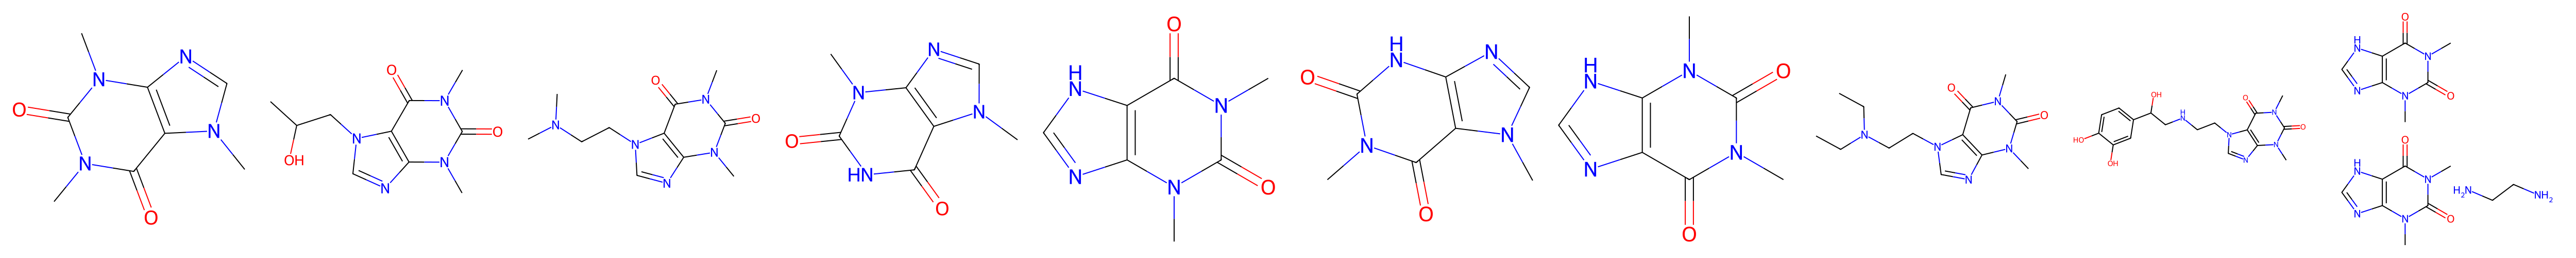

In [53]:
from rdkit.Chem.Draw import MolsToImage
from skfp.distances import tanimoto_count_distance
from sklearn.neighbors import NearestNeighbors

smiles_list, y = load_bbbp()

mol_from_smiles = MolFromSmilesTransformer(suppress_warnings=True)
mols_list = mol_from_smiles.transform(smiles_list)

fp = ECFPFingerprint(count=True)
X = fp.transform(mols_list)

caffeine_mol = mol_from_smiles.transform(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])[0]
caffeine_vec = fp.transform([caffeine_mol])

nn = NearestNeighbors(n_jobs=-1, metric=tanimoto_count_distance)
nn.fit(X)

neighbors_idxs = nn.kneighbors(caffeine_vec, n_neighbors=10, return_distance=False)
neighbors_idxs = neighbors_idxs[0]

nearest_mols = np.array(mols_list)[neighbors_idxs]
nearest_mols = list(nearest_mols)

MolsToImage(nearest_mols, subImgSize=(500, 500))